# Roll centre at speed wPCC

In [30]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
import matplotlib.pyplot as plt
import paper
from paper import save_fig, save_eq
from phd.helpers import derivative
from vessel_manoeuvring_models.data.lowpass_filter import lowpass_filter
from phd.load_data import filter, calculate_accelerometer_corrections, accelerometers_to_origo, calculated_accelerometer, plot_accelerations, plot_accelerometers
from vessel_manoeuvring_models.EKF_multiple_sensors import update_gradient

In [32]:
ship_name = 'wPCC'

In [33]:
ship_data = catalog.load(f"{ship_name}.ship_data")

[12/28/24 15:31:54] INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=599962;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=64323;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [34]:
meta_data_all = catalog.load(f"{ship_name}.time_series_meta_data")

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=879618;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=485177;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [35]:
meta_data_all['test_type'].unique()

array(['reference speed', 'rodergrundvinkel', 'zigzag', 'turning circle', 'sailing', 'roll decay', 'GM', 'unknown'], dtype=object)

In [36]:
meta_datas = meta_data_all.groupby(by='test_type').get_group('roll decay')

In [37]:
meta_datas[['ship_speed']]

,ship_speed
22601,NaN
22602,NaN
22603,NaN
22604,0.96177


In [38]:
#%reload_kedro
id = 22604
#data = load(id=id, catalog=catalog, smooth=False)
data = catalog.load(f"{ship_name}.tests_WL")[str(id)]()

data = filter(data,cutoff=1)
data = data.loc[26:].copy()

                    INFO     Loading data from 'wPCC.tests_WL' (PartitionedDataset)...          ]8;id=188999;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=370549;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

<Axes: xlabel='time'>

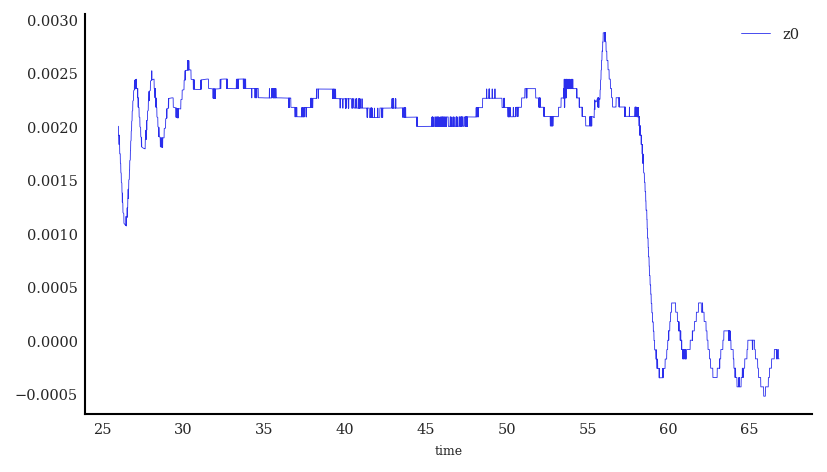

In [39]:
data.plot(y='z0')

<Axes: xlabel='time'>

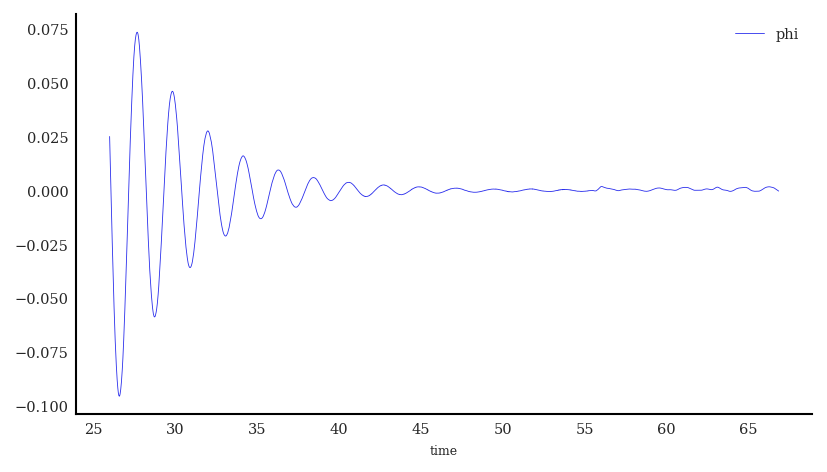

In [40]:
data.plot(y='phi')

In [41]:
tp = 10/20
fp = 1/tp

In [42]:
fp

2.0

In [43]:
dt=0.01
fs = 1/dt

data_highpass = pd.DataFrame(index=data.index)
for key,values in data.items():

    data_highpass[key] = lowpass_filter(data[key], cutoff=0.2, fs=fs, order=2, btype='high')

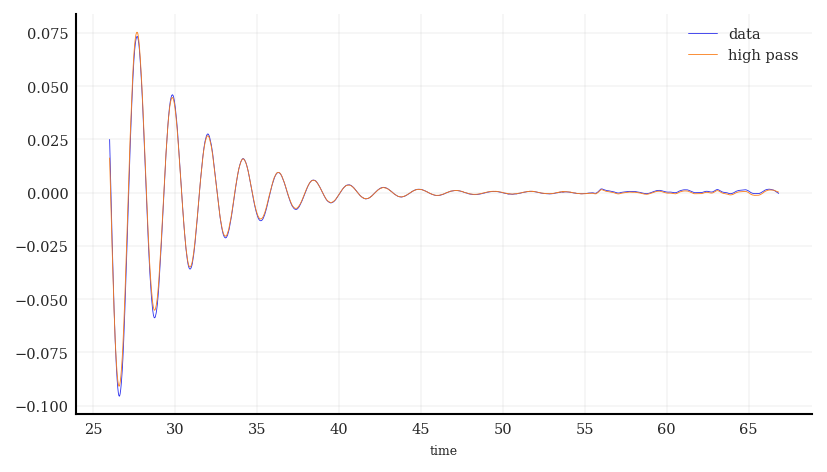

In [44]:
fig,ax=plt.subplots()
data.plot(y='phi',ax=ax, label='data')
data_highpass.plot(y='phi',ax=ax, label='high pass')
ax.grid()

Text(0.5, 1.0, 'Roll decay 22604')

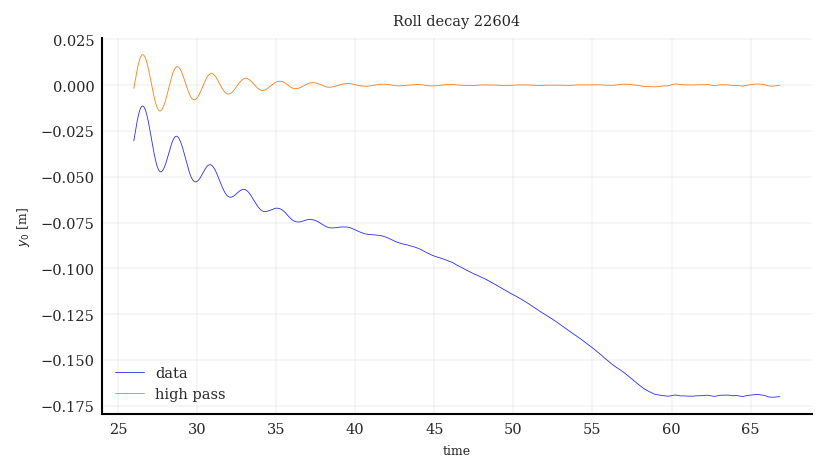

In [45]:
fig,ax=plt.subplots()
data.plot(y='y0',ax=ax, label='data')
data_highpass.plot(y='y0',ax=ax, label='high pass')
ax.grid()
ax.set_ylabel(r'$y_0$ [m]')
ax.set_title(f"Roll decay {id}")
#paper.save_fig(fig,"rolldecay_highpass_y0.svg")

In [46]:
data['zz'] = np.where(data['phi'].abs().between(np.deg2rad(2),np.deg2rad(5)),data_highpass['y0']/np.sin(data['phi']),np.NaN)

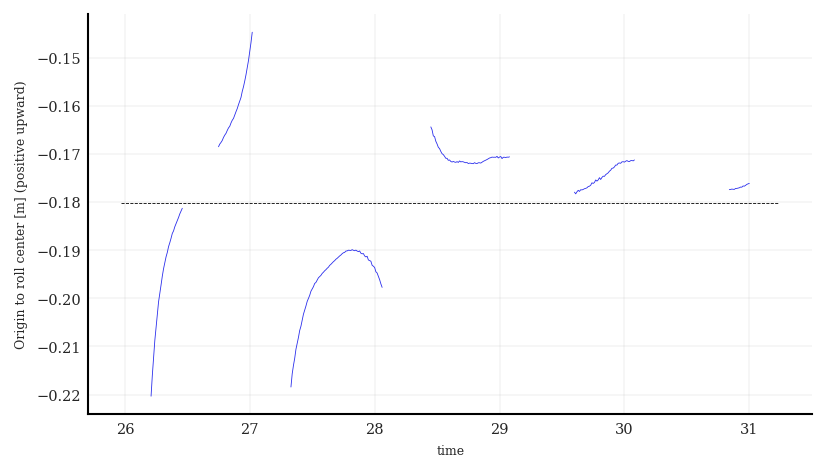

In [47]:
fig,ax=plt.subplots()
data.plot(y='zz',ax=ax)
zz=data['zz'].mean()
xlims=ax.get_xlim()
ax.hlines(y=zz, xmin=xlims[0], xmax=xlims[1], linestyles='dashed', color='k')
ax.set_ylabel(r'Origin to roll center [m] (positive upward)')
ax.get_legend().set_visible(False)
ax.grid()
paper.save_fig(fig, "WL_to_roll_center.svg")

In [48]:
data['zz'].mean()

-0.18025841446871002

In [49]:
data_highpass_corrected = data_highpass.copy()
#zz=0.213
zz=data['zz'].mean()
data_highpass_corrected['y0']-=zz*np.sin(data['phi'])

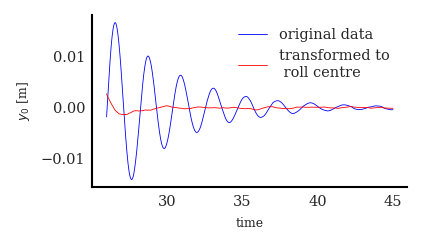

In [50]:
fig,ax=plt.subplots()
data_highpass.loc[0:45].plot(y='y0',ax=ax, label='original data', color='b')
data_highpass_corrected.loc[0:45].plot(y='y0',ax=ax, label='transformed to \n roll centre', color='r')
ax.grid(False)
ax.set_ylabel(r'$y_0$ [m]')
#ax.set_title(f"Roll decay {id}")
fig.set_size_inches(paper.figure_width/2,paper.figure_height/2)
paper.save_fig(fig,"y0_at_roll_center.svg")

## Check zigzag 1

In [51]:
id = 22765
data = catalog.load("wPCC.tests_WL")[str(id)]()
data = filter(data,cutoff=0.5)
#data = data.loc[26:].copy()

[12/28/24 15:31:55] INFO     Loading data from 'wPCC.tests_WL' (PartitionedDataset)...          ]8;id=724454;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=864713;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [52]:
dt=0.01
fs = 1/dt

data_highpass = pd.DataFrame(index=data.index)
for key,values in data.items():

    data_highpass[key] = lowpass_filter(data[key], cutoff=0.2, fs=fs, order=2, btype='high')

<Axes: xlabel='time'>

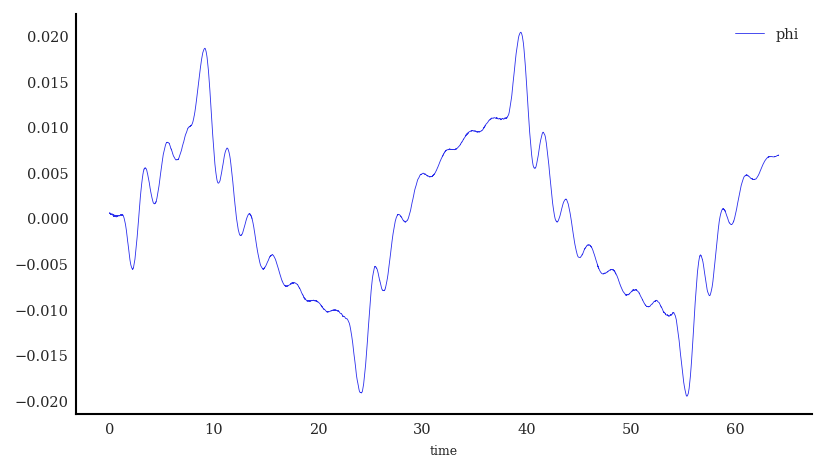

In [53]:
data.plot(y='phi')

<Axes: xlabel='time'>

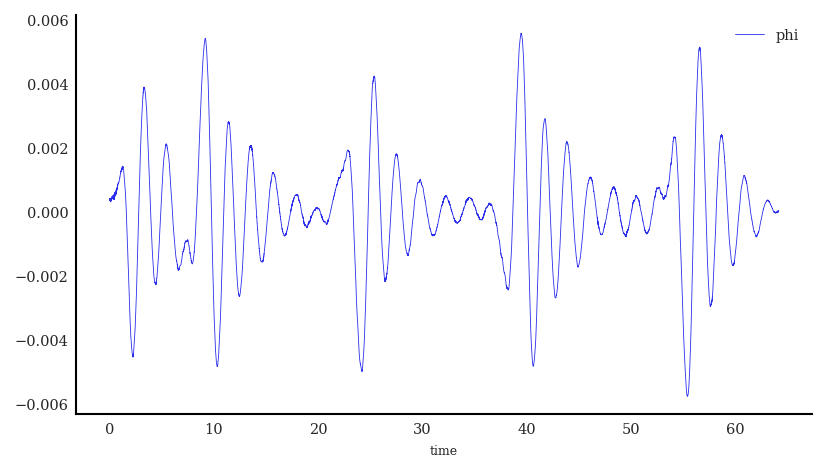

In [54]:
data_highpass.plot(y='phi')

In [55]:
zz

-0.18025841446871002

[12/28/24 15:31:56] INFO     Loading data from 'wPCC.tests_WL' (PartitionedDataset)...          ]8;id=100567;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=63070;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

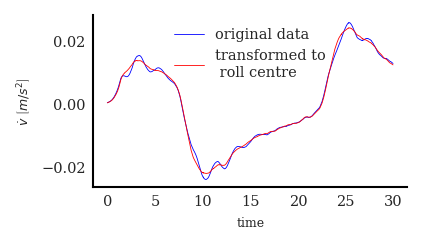

In [56]:
df_ = catalog.load("wPCC.tests_WL")[str(id)]()
df_['y0']-=zz*np.sin(df_['phi'])
df_ = filter(df_,cutoff=0.5)

fig,ax=plt.subplots()
data.loc[0:30].plot(y='v1d', label='original data', ax=ax, color='b')
df_.loc[0:30].plot(y='v1d', label='transformed to\n roll centre', ax=ax, color='r')
ax.set_ylabel(r'$\dot{v}$ $\left[m/s^2\right]$')
#ax.set_title(f"Zigzag10/10 {id}")
fig.set_size_inches(paper.figure_width/2,paper.figure_height/2)
paper.save_fig(fig,"zz10_v1d_at_roll_centre.svg")